##### Object Detection Using YOLOv5: Inference and Visualization

This project demonstrates the use of the YOLOv5 model for object detection in both PyTorch and ONNX frameworks. The goal is to perform object detection on the MS COCO validation or test dataset.


In [32]:
import torch
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from ultralytics import YOLO
import os
import numpy as np
from collections import defaultdict

# Load the pre-trained YOLOv5 model (you can also load a custom trained model)
model = YOLO("yolov5su.pt")  # Replace with your model if it's custom
coco_classes = model.names  # This is a dictionary, not a list


image_dir = 'coco128/images/train2017'
label_dir = 'coco128/labels/train2017'

In [2]:
def load_ground_truth(image_path, label_path):
    image = Image.open(image_path)
    original_width, original_height = image.size

    def read_labels(label_path):
        labels = []
        with open(label_path, 'r') as f:
            for line in f:
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                x1 = (x_center - width / 2) * original_width
                y1 = (y_center - height / 2) * original_height
                x2 = (x_center + width / 2) * original_width
                y2 = (y_center + height / 2) * original_height
                labels.append([class_id, x_center, y_center, width, height])
        return np.array(labels)
    
    ground_truth_labels = read_labels(label_path)
    # Find unique class IDs from the ground truth labels
    #unique_class_ids = np.unique(ground_truth_labels[:, 0])

    gt_boxes = []
    for label in ground_truth_labels:
        class_id, x_center, y_center, width, height = label
        x1 = (x_center - width / 2) * original_width
        y1 = (y_center - height / 2) * original_height
        x2 = (x_center + width / 2) * original_width
        y2 = (y_center + height / 2) * original_height
        gt_boxes.append([class_id, [x1, y1, x2, y2]])
    return image, gt_boxes



In [3]:
def model_inference(image_path):
    results = model(image_path)
    #print(results)
    detection = results[0]
    #print(results[0].boxes)

    pred_boxes = detection.boxes.xyxy
    pred_conf = detection.boxes.conf
    pred_classes=detection.boxes.cls

    return  pred_boxes, pred_conf, pred_classes

In [26]:
def plot_results(image, gt_boxes, pred_boxes=None, pred_conf=None, pred_classes=None, is_pred_visualize=False, target_class_id=None):

    # Find unique class IDs from the ground truth labels
    #unique_class_ids = np.unique([gt_box[0] for gt_box in gt_boxes])

    # Loop over each unique class id in the ground truth
    #for target_class_id in unique_class_ids:
    fig, ax = plt.subplots(1, figsize=(8,6))
    ax.imshow(image)

    # Plot ground truth boxes for the current target class
    for gt_box in gt_boxes:
        gt_class_id, box = gt_box
        if gt_class_id == target_class_id:
            x1, y1, x2, y2 = box
            ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=2))
            ax.text(x1 - 10, y1 - 10, coco_classes[gt_class_id], color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

        
    if is_pred_visualize == True:
        for i in range(len(pred_boxes)):
            box = pred_boxes[i].cpu().numpy()  # Get predicted box
            score = pred_conf[i].cpu().item()  # Get confidence score
            pred_class_id = int(pred_classes[i].cpu().item())  # Get predicted class ID
            class_name = coco_classes[pred_class_id]  # Get class name

            if pred_class_id == target_class_id:  # Only plot predictions for the current class
                x1, y1, x2, y2 = box
                ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='#042aff', linewidth=2))
                ax.text(x1+(x2 - x1), y1,  f'{class_name} {score:.2f}', horizontalalignment='left',color='white', fontsize=12, bbox=dict(facecolor='#042aff', alpha=0.5))

        # Add title to the image for class-wise comparison
        ax.set_title(f'{coco_classes[target_class_id].capitalize()}')
        ax.axis('off')

        # Display the image with both ground truth and predicted boxes for the current class
        plt.show()

In [15]:
def calculate_iou(gt_box, pred_box):
    # Calculate Intersection over Union (IoU)
    #class_id, box = gt_box
    x1_gt, y1_gt, x2_gt, y2_gt = gt_box
    x1_pred, y1_pred, x2_pred, y2_pred = pred_box

    # Calculate intersection
    inter_x1 = max(x1_gt, x1_pred)
    inter_y1 = max(y1_gt, y1_pred)
    inter_x2 = min(x2_gt, x2_pred)
    inter_y2 = min(y2_gt, y2_pred)

    # Check for no intersection
    if inter_x2 <= inter_x1 or inter_y2 <= inter_y1:
        return 0.0

    # Calculate area of intersection
    intersection_area = (inter_x2 - inter_x1) * (inter_y2 - inter_y1)

    # Calculate areas
    gt_area = (x2_gt - x1_gt) * (y2_gt - y1_gt)
    pred_area = (x2_pred - x1_pred) * (y2_pred - y1_pred)

    # Calculate IoU
    union_area = gt_area + pred_area - intersection_area
    iou = intersection_area / union_area
    return iou


0: 448x640 1 potted plant, 1 vase, 126.2ms
Speed: 1.0ms preprocess, 126.2ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)
class ids:tensor([75., 58.])


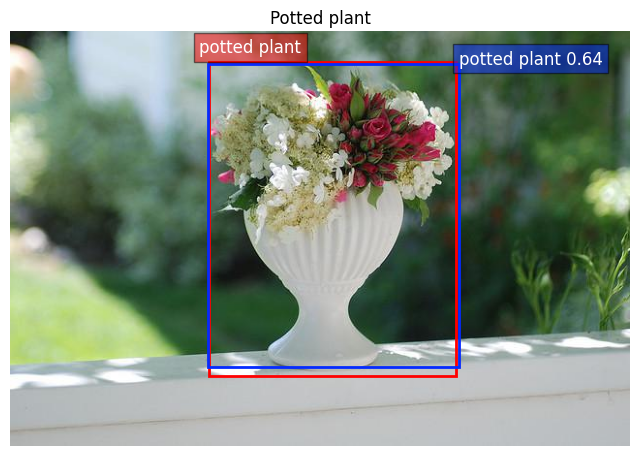

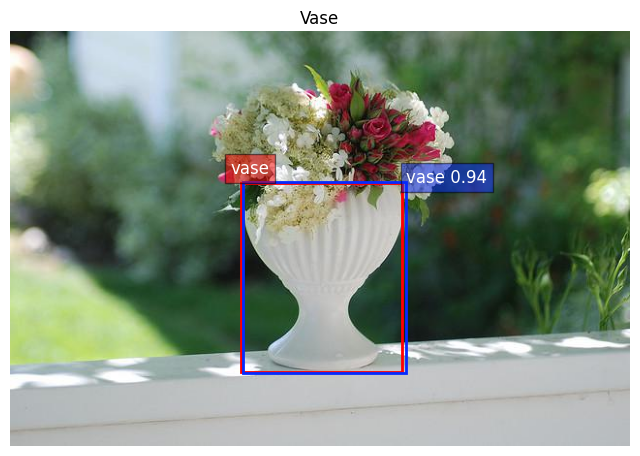


0: 448x640 2 giraffes, 129.9ms
Speed: 1.4ms preprocess, 129.9ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)
class ids:tensor([23., 23.])


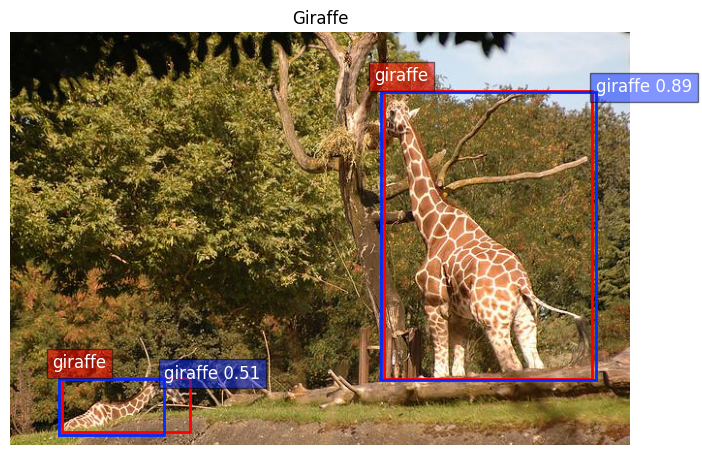


0: 480x640 3 bowls, 2 broccolis, 1 dining table, 281.1ms
Speed: 1.0ms preprocess, 281.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)
class ids:tensor([45., 45., 50., 45., 60., 50.])


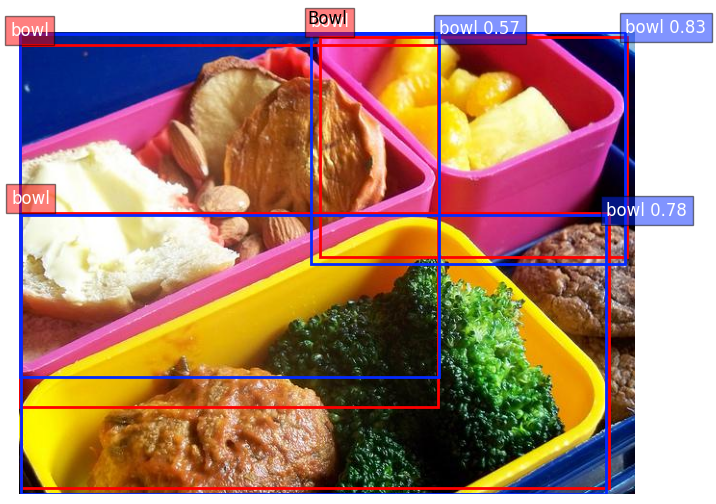

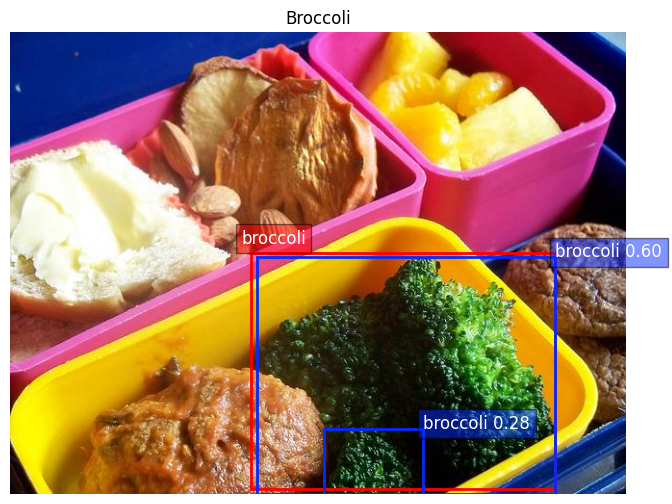

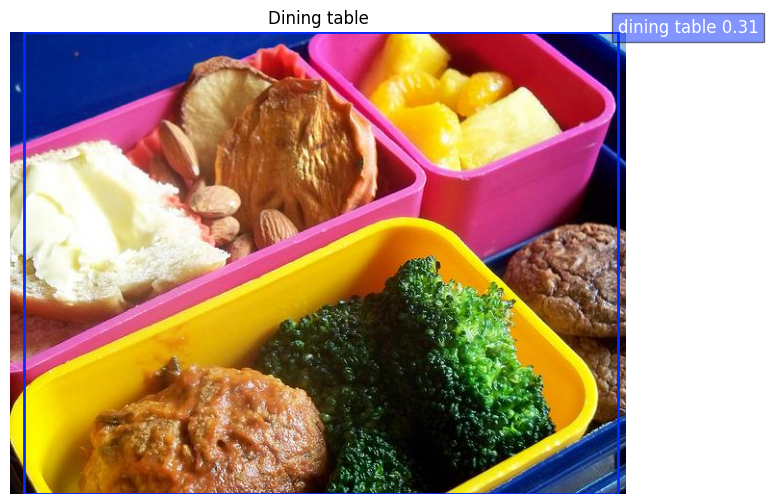


0: 448x640 1 zebra, 233.3ms
Speed: 2.0ms preprocess, 233.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)
class ids:tensor([22.])


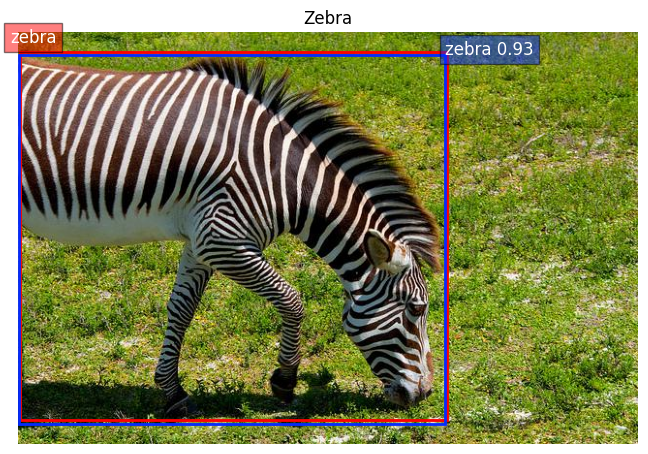

Total IoU values collected: 11
[22, 23, 45, 50, 58, 60, 75]


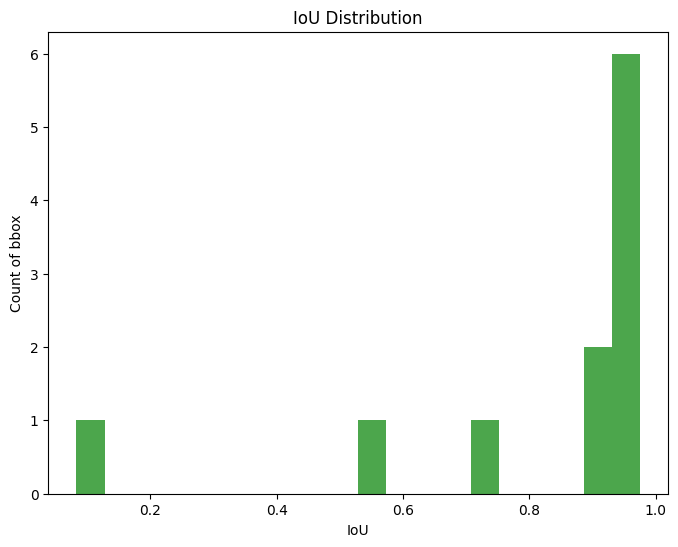

In [27]:
all_pred_class_ids = set()  # To store all unique predicted class ids across images
iou_values = []

# Loop over all images in the image directory
for image_name in sorted(os.listdir(image_dir)):
    if image_name.endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(image_dir, image_name)
        # Get the file name without extension
        file_name, file_extension = os.path.splitext(image_name)
        # Replace the image extension with .txt for the label path
        label_path = os.path.join(label_dir, file_name + '.txt')

        # Open the image and get its original size
        image, gt_boxes = load_ground_truth(img_path, label_path)
        original_width, original_height = image.size  # Store the original image dimensions

        pred_boxes, pred_conf, pred_classes = model_inference(image)
        print(f'class ids:{pred_classes}')
        
        # Collect unique class ids from predicted classes for the current image
        unique_pred_classes = np.unique(pred_classes)
        all_pred_class_ids.update(map(int, unique_pred_classes))   # Add the unique class ids from this image to the set
        
        # Loop over each unique class id in the ground truth (if needed)
        for target_class_id in unique_pred_classes:
            plot_results(image, gt_boxes, pred_boxes, pred_conf, pred_classes, is_pred_visualize=True, target_class_id=target_class_id)
        
        # For IoU calculation, find the best match (max IoU) for each predicted box
        for i in range(len(pred_boxes)):
            max_iou = 0  # Initialize max IoU for this prediction
            best_gt_box = None  # Initialize best ground truth box for this prediction
            
            for gt_box in gt_boxes:
                _, gt_box_coords = gt_box  # Extract ground truth box coordinates
                iou = calculate_iou(gt_box_coords, pred_boxes[i])  # Calculate IoU
                
                if iou > max_iou:
                    max_iou = iou  # Update max IoU
                    best_gt_box = gt_box  # Update the best matching ground truth box
            
            # Append the max IoU value to the list of IoU values
            iou_values.append(max_iou)

print(f'Total IoU values collected: {len(iou_values)}')


# Print unique predicted class ids across all images
print(sorted(all_pred_class_ids))


# Plot IoU histogram
plt.figure(figsize=(8, 6))
plt.hist(iou_values, bins=20, color='green', alpha=0.7)
plt.title('IoU Distribution')
plt.xlabel('IoU')
plt.ylabel('Count of bbox')

plt.show()

#### summary
- Box labels 
    1. RED BOX - groundtruth label 
    2. Blue BOX - predection boxes 
- High IoU values (close to 1) indicate that the predicted bounding boxes closely match the ground truth.
- Low IoU values (close to 0) suggest poor alignment between the predicted and ground truth boxes.

- Total count of bounding boxes is 11
- only 1 bbox is less than 0.5 and remaining are greater than 0.5 threshold.
- missing one groundtruth label for dinning table.

##### ONNX inference

In [28]:
# Export the model to ONNX format
model.export(format="onnx")

Ultralytics 8.3.55 🚀 Python-3.10.12 torch-2.5.1+cu118 CPU (11th Gen Intel Core(TM) i7-1165G7 2.80GHz)

PyTorch: starting from 'yolov5su.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (17.7 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.47...
ONNX: export success ✅ 1.1s, saved as 'yolov5su.onnx' (35.1 MB)

Export complete (1.5s)
Results saved to /home/deltlo27/Documents/project/Task5
Predict:         yolo predict task=detect model=yolov5su.onnx imgsz=640  
Validate:        yolo val task=detect model=yolov5su.onnx imgsz=640 data=coco.yaml  
Visualize:       https://netron.app


'yolov5su.onnx'

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
Loading yolov5su.onnx for ONNX Runtime inference...
Using ONNX Runtime CPUExecutionProvider

Found https://ultralytics.com/images/bus.jpg locally at bus.jpg
image 1/1 /home/deltlo27/Documents/project/Task5/bus.jpg: 640x640 4 persons, 1 bus, 167.4ms
Speed: 3.0ms preprocess, 167.4ms inference, 30.5ms postprocess per image at shape (1, 3, 640, 640)


(np.float64(-0.5), np.float64(809.5), np.float64(1079.5), np.float64(-0.5))

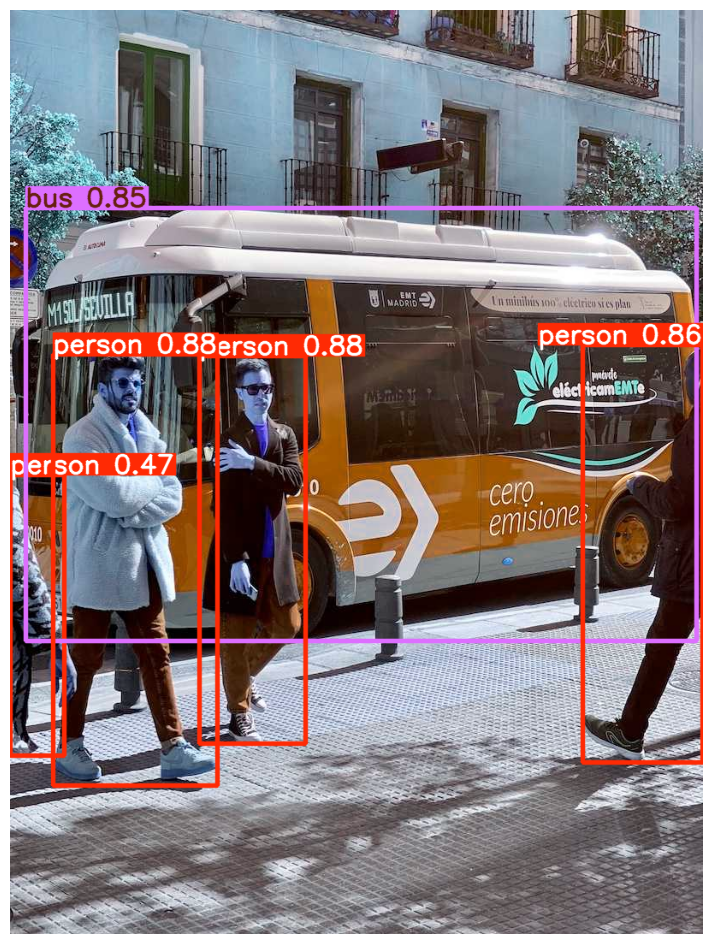

In [42]:
# Load the exported ONNX model
onnx_model = YOLO("yolov5su.onnx")

# Run inference
results = onnx_model("https://ultralytics.com/images/bus.jpg")
ims=results[0].plot()
# Plot class distributions
plt.figure(figsize=(12, 12))
plt.imshow(ims)
plt.axis('off')
